In [1]:
import numpy as np
import pandas as pd

import scipy.stats as ss

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score

import catboost as catb
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pprint import pprint

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Построение модели классификации

### 1. Обзор обучающего датасета


#### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/ML_project/'
TRAIN_DATASET_PATH = PATH + 'course_project_train.csv'
TEST_DATASET_PATH = PATH + 'course_project_test.csv'
PREP_DATASET_PATH = PATH + 'course_project_prep_train.csv'

### 2. Загрузка данных

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1


In [5]:
TARGET_NAME = 'Credit Default'
X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]
print('X.shape = ', X.shape)
print('y.shape = ', y.shape)

X.shape =  (7500, 16)
y.shape =  (7500,)


In [6]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [7]:
X_final = pd.read_csv(TEST_DATASET_PATH)
print('X_final.shape', X_final.shape)
X_final.head(2)

X_final.shape (2500, 16)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0


#### Пропуски данных

In [8]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [9]:
NUMERIC_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 
                         'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
                         'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CATEGORICAL_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Purpose', 'Term']

### 3. Создание групп для Weight of Evidence (WOE) 

Ввиду того, что выборка несбалансированна, будем использовать Weight of Evidence (WOE) признаков

In [10]:
bin_split_numeric = {}
WOE = {}

### A. Numeric variables

In [11]:
def WOE_calc_numeric(feature, bin_split):
    feature_dict = {}
    if df[feature].isnull().sum() > 0:
        a = df.loc[df[feature].isnull(), 'Credit Default']
        print(f'n_items bin nan = {len(a)}')
        a = a.mean()
        if a == 1.0:
            WOE_ = 10
        elif a == 0:
            WOE_ = -10
        else:
            WOE_ = np.log(a / (1 - a)) 
        feature_dict['nan'] = WOE_

    for i in range(1, len(bin_split)):
        cond_1 = df[feature] >= bin_split[i - 1]
        cond_2 = df[feature] < bin_split[i]
        a = df.loc[(cond_1 & cond_2), 'Credit Default']
        print(f'n_items bin {int(bin_split[i])} = {len(a)}')
        a = a.mean()
        if a == 1.0:
            WOE_ = 10
        elif a == 0:
            WOE_ = -10
        else:
            WOE_ = np.log(a / (1 - a)) 
        feature_dict[bin_split[i]] = WOE_
        
    bin_split_numeric[feature] = bin_split
    WOE[feature] = feature_dict   

#### 1. Annual Income

In [12]:
feature = 'Annual Income'
bin_split = [0, 7.5e+05, 1e+06, 1.3e+06, 1.8e+06, 3.1e+07]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin nan = 1557
n_items bin 750000 = 1054
n_items bin 1000000 = 1178
n_items bin 1300000 = 1167
n_items bin 1800000 = 1379
n_items bin 31000000 = 1165

WOE per bin:


{'nan': -0.664382014156811,
 750000.0: -0.6775329527583945,
 1000000.0: -0.8489153294013843,
 1300000.0: -0.9434417209401059,
 1800000.0: -1.1845911410435503,
 31000000.0: -1.4242804799359772}

#### 2. Number of Open Accounts

In [13]:
feature = 'Number of Open Accounts'
bin_split = [0, 9, 13, 18, 9999]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 9 = 2415
n_items bin 13 = 2659
n_items bin 18 = 1695
n_items bin 9999 = 731

WOE per bin:


{9: -1.0436025047360038,
 13: -0.9286968564142538,
 18: -0.8543312274033161,
 9999: -0.8104362670830454}

#### 3. Years of Credit History

In [14]:
feature = 'Years of Credit History'
bin_split = [0, 10, 13, 16, 99]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 10 = 590
n_items bin 13 = 1037
n_items bin 16 = 1508
n_items bin 99 = 4365

WOE per bin:


{10: -0.6829948090959274,
 13: -0.8801180004804297,
 16: -0.9321271131370563,
 99: -0.9871384222049912}

#### 4. Maximum Open Credit

In [15]:
feature = 'Maximum Open Credit'
bin_split = [0, 0.15e+06, 0.25e+06, 0.35e+06, 0.5e+06, 0.7e+06, 1.1e+06, 9e+09]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 150000 = 624
n_items bin 250000 = 956
n_items bin 350000 = 1019
n_items bin 500000 = 1313
n_items bin 700000 = 1278
n_items bin 1100000 = 1329
n_items bin 9000000000 = 981

WOE per bin:


{150000.0: -0.7003674285334326,
 250000.0: -0.7823783142878881,
 350000.0: -0.9460198483458652,
 500000.0: -0.8433116257193687,
 700000.0: -0.9555114450274363,
 1100000.0: -1.0363699797908887,
 9000000000.0: -1.2235116141822528}

#### 5. Number of Credit Problems

In [16]:
feature = 'Number of Credit Problems'
bin_split = [0, 1, 99]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 1 = 6469
n_items bin 99 = 1031

WOE per bin:


{1: -0.9416415971632859, 99: -0.9000522153812469}

#### 6. Months since last delinquent

In [17]:
feature = 'Months since last delinquent'
bin_split = [0, 13, 999]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin nan = 4081
n_items bin 13 = 617
n_items bin 999 = 2802

WOE per bin:


{'nan': -0.9599264632365533, 13: -0.7645181744518642, 999: -0.9401462259633803}

#### 7. Bankruptcies

Ввиду малочисленности, пропуски игнорируем

In [18]:
feature = 'Bankruptcies'
bin_split = [0, 1, 99]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature].pop('nan')
WOE[feature]

n_items bin nan = 14
n_items bin 1 = 6660
n_items bin 99 = 826

WOE per bin:


{1: -0.9346514882500618, 99: -0.9461436950238364}

#### 8. Current Loan Amount

In [19]:
feature = 'Current Loan Amount'
bin_split = [0, 0.15e+06, 0.25e+06, 0.35e+06, 0.5e+06, 1e+06, 1e+08]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 150000 = 1341
n_items bin 250000 = 1654
n_items bin 350000 = 1400
n_items bin 500000 = 1157
n_items bin 1000000 = 1078
n_items bin 100000000 = 870

WOE per bin:


{150000.0: -0.9351592161785379,
 250000.0: -0.8536397669124878,
 350000.0: -0.747214401830221,
 500000.0: -0.664758177297259,
 1000000.0: -0.5356407928857146,
 100000000.0: -10}

#### 9. Current Credit Balance

In [20]:
feature = 'Current Credit Balance'
bin_split = [0, 0.2e+06, 0.5e+06, 1e+07]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 200000 = 3606
n_items bin 500000 = 2828
n_items bin 10000000 = 1066

WOE per bin:


{200000.0: -0.9522883588207761,
 500000.0: -0.9024701762555227,
 10000000.0: -0.9701064395703548}

#### 10. Monthly Debt

In [21]:
feature = 'Monthly Debt'
bin_split = [0, 0.06e+05, 0.1e+05, 0.3e+05, 1e+06]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin 6000 = 794
n_items bin 10000 = 1052
n_items bin 30000 = 4636
n_items bin 1000000 = 1018

WOE per bin:


{6000.0: -1.1154760947201146,
 10000.0: -0.9996440718624063,
 30000.0: -0.9042423933579806,
 1000000.0: -0.8821577255046966}

#### 11. Credit Score

In [22]:
feature = 'Credit Score'
bin_split = [0, 710, 730, 742, 755, 9999]
WOE_calc_numeric(feature, bin_split)
print('\nWOE per bin:')
WOE[feature]

n_items bin nan = 1557
n_items bin 710 = 1410
n_items bin 730 = 1377
n_items bin 742 = 1473
n_items bin 755 = 1283
n_items bin 9999 = 400

WOE per bin:


{'nan': -0.664382014156811,
 710: -0.7773392717802932,
 730: -1.1665852722543157,
 742: -1.485107755783986,
 755: -2.091776499837787,
 9999: 10}

### B. Categorical variables

In [23]:
def calc_a(sub_category):    
    cond = df[feature] == sub_category[0]
    for j in range(1, len(sub_category)):
        cond |= (df[feature] == sub_category[j])        
    a = df.loc[cond, 'Credit Default']    
    return a

def WOE_calc(feature, category_list):
    feature_dict = {}
    if df[feature].isnull().sum() > 0:
        a = df.loc[df[feature].isnull(), 'Credit Default']
        print(f'n_items category nan = {len(a)}')
        a = a.mean()
        if a == 1.0:
            WOE_ = 10
        elif a == 0:
            WOE_ = -10
        else:
            WOE_ = np.log(a / (1 - a)) 
        feature_dict['nan'] = WOE_
    
    for i in range(len(category_list)):
        if isinstance(category_list[i], list):
            a = calc_a(category_list[i])
        else:
            a = df.loc[df[feature] == category_list[i], 'Credit Default']
        print(f'{len(a)}\t{category_list[i]}')
        a = a.mean()
        if a == 1.0:
            WOE_ = 10
        elif a == 0:
            WOE_ = -10
        else:
            WOE_ = np.log(a / (1 - a))        
        
        if isinstance(category_list[i], list):
            for category in category_list[i]:
                feature_dict[category] = WOE_
        else:
            feature_dict[category_list[i]] = WOE_
            
    bin_split_categorical[feature] = category_list
    WOE[feature] = feature_dict    

In [24]:
bin_split_categorical = {}

#### 1. Home Ownership

In [25]:
feature = 'Home Ownership'
df[feature].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Из-за того, что группа 'Have Mortgage' слишком малочисленна, объединим ее с группой 'Home Mortgage'

In [26]:
category_list = [['Home Mortgage', 'Have Mortgage'], 'Rent', 'Own Home']
WOE_calc(feature, category_list)
print('\nWOE per category:')
WOE[feature]

3649	['Home Mortgage', 'Have Mortgage']
3204	Rent
647	Own Home

WOE per category:


{'Home Mortgage': -1.0902257308532148,
 'Have Mortgage': -1.0902257308532148,
 'Rent': -0.7859162935645262,
 'Own Home': -0.862802046923169}

#### 2. Years in current job

In [27]:
feature = 'Years in current job'
df[feature].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Объединим группы:
* < 1 year, 1 year 
* 2 years, 3 years
* 4 years, 5 years, 6 years, 7 years
* 8 years, 9 years, 10+ years

Ввиду малочисленности, пропуски игнорируем

In [28]:
category_list = [['< 1 year', '1 year'],
                 ['2 years', '3 years'],
                 ['4 years', '5 years', '6 years', '7 years'],
                 ['8 years', '9 years', '10+ years']]
WOE_calc(feature, category_list)
print('\nWOE per category:')
WOE[feature].pop('nan')
WOE[feature]

n_items category nan = 371
1067	['< 1 year', '1 year']
1325	['2 years', '3 years']
1807	['4 years', '5 years', '6 years', '7 years']
2930	['8 years', '9 years', '10+ years']

WOE per category:


{'< 1 year': -0.9340719049917153,
 '1 year': -0.9340719049917153,
 '2 years': -0.9746116164008557,
 '3 years': -0.9746116164008557,
 '4 years': -0.9306682867085156,
 '5 years': -0.9306682867085156,
 '6 years': -0.9306682867085156,
 '7 years': -0.9306682867085156,
 '8 years': -0.9775467178251201,
 '9 years': -0.9775467178251201,
 '10+ years': -0.9775467178251201}

#### 3. Tax Liens

In [29]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Признак не информативный. Использовать не будем

In [30]:
CATEGORICAL_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

#### 4. Purpose

In [31]:
feature = 'Purpose'
df[feature].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Выделим категории debt consolidation и home improvements, а остальные объединим в одну группу

In [32]:
category_list = ['debt consolidation', 'home improvements', 
                 ['other', 'business loan', 'buy a car', 'medical bills', 
                  'major purchase', 'take a trip', 'buy house', 
                  'small business', 'wedding', 'moving', 
                  'educational expenses', 'vacation', 'renewable energy']]
WOE_calc(feature, category_list)
print('\nWOE per category:')
WOE[feature]

5944	debt consolidation
412	home improvements
1144	['other', 'business loan', 'buy a car', 'medical bills', 'major purchase', 'take a trip', 'buy house', 'small business', 'wedding', 'moving', 'educational expenses', 'vacation', 'renewable energy']

WOE per category:


{'debt consolidation': -0.9530901363384262,
 'home improvements': -1.034896474282002,
 'other': -0.8150369981689821,
 'business loan': -0.8150369981689821,
 'buy a car': -0.8150369981689821,
 'medical bills': -0.8150369981689821,
 'major purchase': -0.8150369981689821,
 'take a trip': -0.8150369981689821,
 'buy house': -0.8150369981689821,
 'small business': -0.8150369981689821,
 'wedding': -0.8150369981689821,
 'moving': -0.8150369981689821,
 'educational expenses': -0.8150369981689821,
 'vacation': -0.8150369981689821,
 'renewable energy': -0.8150369981689821}

#### 5. Term

In [33]:
feature = 'Term'
df[feature].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [34]:
category_list = ['Short Term', 'Long Term']
WOE_calc(feature, category_list)
print('\nWOE per category:')
WOE[feature]

5556	Short Term
1944	Long Term

WOE per category:


{'Short Term': -1.1889804856067696, 'Long Term': -0.3237870770938973}

### 4. Feature Engineering

In [35]:
class FeatureGenerator:
    def __init__(self, bin_split_numeric, bin_split_categorical):
        self.bin_split_numeric = bin_split_numeric
        self.bin_split_categorical = bin_split_categorical
        
        
    def WOE_formula(self, a):
        a = a.mean()
        if a == 1.0:
            WOE_ = 10
        elif a == 0:
            WOE_ = -10
        else:
            WOE_ = np.log(a / (1 - a))
        return WOE_
    
        
    def WOE_calc_numeric(self, feature):
        feature_dict = {}
        if df[feature].isnull().sum() > 0:
            a = df.loc[df[feature].isnull(), 'Credit Default']
            feature_dict['nan'] = self.WOE_formula(a)

        for i in range(1, len(self.bin_split_numeric[feature])):
            cond_1 = df[feature] >= self.bin_split_numeric[feature][i - 1]
            cond_2 = df[feature] < self.bin_split_numeric[feature][i]
            a = df.loc[(cond_1 & cond_2), 'Credit Default']            

            feature_dict[self.bin_split_numeric[feature][i]] = self.WOE_formula(a) 

        return feature_dict
    
    
    def calc_a(self, feature, sub_category):    
        cond = df[feature] == sub_category[0]
        for j in range(1, len(sub_category)):
            cond |= (df[feature] == sub_category[j]) 
            
        a = df.loc[cond, 'Credit Default']
        
        return a
    
    
    def WOE_calc_categorical(self, feature):
        feature_dict = {}
        if df[feature].isnull().sum() > 0:
            a = df.loc[df[feature].isnull(), 'Credit Default'] 
            feature_dict['nan'] = self.WOE_formula(a)

        for i in range(len(self.bin_split_categorical[feature])):
            sub_category = self.bin_split_categorical[feature][i]
            if isinstance(sub_category, list):                
                a = self.calc_a(feature, sub_category)                
            else:
                a = df.loc[df[feature] == sub_category, 'Credit Default']  
            WOE_ = self.WOE_formula(a)            

            if isinstance(sub_category, list):                
                for item in sub_category:                    
                    feature_dict[item] = WOE_
            else:
                feature_dict[sub_category] = WOE_
        
        return feature_dict 
        
    
    def fit(self, X, y=None):
        df = X.copy()
        
        if y is not None:
            df['Credit Default'] = y.values 
            
            self.WOE = {}
            for feature in NUMERIC_FEATURE_NAMES:
                self.WOE[feature] = self.WOE_calc_numeric(feature)
                
            for feature in CATEGORICAL_FEATURE_NAMES:
                self.WOE[feature] = self.WOE_calc_categorical(feature)  

    
    def transform(self, X):
        for feature in NUMERIC_FEATURE_NAMES:
            new_feature = feature + '_'        
            if X[feature].isnull().sum() > 0:
                X.loc[X[feature].isnull(), new_feature] = self.WOE[feature]['nan']            
            
            feature_list = self.bin_split_numeric[feature]
            for i in range(1, len(feature_list)):
                cond_1 = X[feature] >= feature_list[i - 1]
                cond_2 = X[feature] < feature_list[i]
                X.loc[(cond_1 & cond_2), new_feature] = self.WOE[feature][feature_list[i]]
        

        for feature in CATEGORICAL_FEATURE_NAMES:
            new_feature = feature + '_'
            if X[feature].isnull().sum() > 0:
                X.loc[X[feature].isnull(), new_feature] = self.WOE[feature]['nan']
                
            feature_list = self.WOE[feature]
            for item in feature_list:        
                X.loc[X[feature] == item, new_feature] = self.WOE[feature][item]
        return X

### 5. Tain_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    stratify = y,
                                                    test_size=0.2, random_state=42)

In [37]:
features = FeatureGenerator(bin_split_numeric, bin_split_categorical)
features.fit(X_train, y_train)
X_train = features.transform(X_train)
X_test = features.transform(X_test)

### 6. Балансировка классов


In [38]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_ros))

Original dataset shape Counter({0: 4310, 1: 1690})
Resample dataset shape Counter({0: 4310, 1: 4310})


### 7. Отбор признаков

In [39]:
SELECTED_FEATURE_NAMES = ['Annual Income_', 'Number of Open Accounts_','Years of Credit History_', 
                          'Maximum Open Credit_', 'Number of Credit Problems_', 'Months since last delinquent_',
                          'Bankruptcies_', 'Current Loan Amount_', 'Current Credit Balance_', 
                          'Monthly Debt_', #'Credit Score_',
                          
                          'Home Ownership_', 'Years in current job_', 'Purpose_', 'Term_']

In [40]:
scaler = StandardScaler()

df_norm = X_train_ros[SELECTED_FEATURE_NAMES].copy()
df_norm[SELECTED_FEATURE_NAMES] = scaler.fit_transform(df_norm[SELECTED_FEATURE_NAMES])

X_train_ros = df_norm.copy()

### 8. Модель

In [41]:
kfold =  StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
def cv_f1_score(model):
    f1_score_list = []
    for train_index, test_index in kfold.split(X, y):
        X_train_cv, X_test_cv = X.loc[train_index, :], X.loc[test_index, :]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        features = FeatureGenerator(bin_split_numeric, bin_split_categorical)
        features.fit(X_train_cv, y_train_cv)
        X_train_cv = features.transform(X_train_cv)
        X_test_cv = features.transform(X_test_cv)
        
        X_train_ros_cv, y_train_ros_cv = ros.fit_resample(X_train_cv, y_train_cv)

        model.fit(X_train_ros_cv[SELECTED_FEATURE_NAMES], y_train_ros_cv)

        y_train_pred_cv = model.predict(X_train_ros_cv[SELECTED_FEATURE_NAMES])
        y_test_pred_cv = model.predict(X_test_cv[SELECTED_FEATURE_NAMES])

        f1_score_list.append(f1_score(y_test_cv, y_test_pred_cv, average=None)[1])
    print(f'cross_validation_f1_score_test = {np.array(f1_score_list).mean()}\n')

In [42]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('roc_auc_score =', roc_auc_score(y_train_true, y_train_pred), '\n')
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('roc_auc_score =', roc_auc_score(y_test_true, y_test_pred), '\n')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred)) 

#### CatBoostClassifier

In [43]:
model_cb = catb.CatBoostClassifier(n_estimators=100,                  
                                   learning_rate=0.5,
                                   silent=True, random_state=21)
model_cb.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_cb.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_cb.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_cb)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

#F1 > 0.5
# 0.5082457922026244

cross_validation_f1_score_test = 0.4413622183505549

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      4310
           1       0.81      0.87      0.84      4310

    accuracy                           0.84      8620
   macro avg       0.84      0.84      0.84      8620
weighted avg       0.84      0.84      0.84      8620

roc_auc_score = 0.8354988399071926 

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1077
           1       0.00      0.00      0.00       423

    accuracy                           0.72      1500
   macro avg       0.36      0.50      0.42      1500
weighted avg       0.52      0.72      0.60      1500

roc_auc_score = 0.5 

CONFUSION MATRIX

col_0              0
Credit Default      
0               1077
1                423


#### RandomForestClassifier

In [44]:
model_rf = RandomForestClassifier(n_estimators=200,  
                                  max_depth=6,                                  
                                  min_samples_leaf=3,
                                  random_state=42)

model_rf.fit(X_train_ros[SELECTED_FEATURE_NAMES].fillna(0), y_train_ros)

y_train_pred = model_rf.predict(X_train_ros[SELECTED_FEATURE_NAMES].fillna(0))
y_test_pred = model_rf.predict(X_test[SELECTED_FEATURE_NAMES].fillna(0))

cv_f1_score(model_rf)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

# 0.5446845116168115

cross_validation_f1_score_test = 0.5039557188291318

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.59      0.65      4310
           1       0.65      0.76      0.70      4310

    accuracy                           0.68      8620
   macro avg       0.68      0.68      0.67      8620
weighted avg       0.68      0.68      0.67      8620

roc_auc_score = 0.6764501160092808 

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1077
           1       0.00      0.00      0.00       423

    accuracy                           0.72      1500
   macro avg       0.36      0.50      0.42      1500
weighted avg       0.52      0.72      0.60      1500

roc_auc_score = 0.5 

CONFUSION MATRIX

col_0              0
Credit Default      
0               1077
1                423


#### AdaBoostClassifier

In [45]:
model_ab = AdaBoostClassifier(n_estimators=80, 
                              learning_rate = 0.65,
                           random_state=42)
model_ab.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_ab.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_ab.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model_ab)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

# 0.5447539559328145

cross_validation_f1_score_test = 0.5072691327035382

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.57      0.62      4310
           1       0.63      0.73      0.68      4310

    accuracy                           0.65      8620
   macro avg       0.65      0.65      0.65      8620
weighted avg       0.65      0.65      0.65      8620

roc_auc_score = 0.6498839907192575 

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1077
           1       0.00      0.00      0.00       423

    accuracy                           0.72      1500
   macro avg       0.36      0.50      0.42      1500
weighted avg       0.52      0.72      0.60      1500

roc_auc_score = 0.5 

CONFUSION MATRIX

col_0              0
Credit Default      
0               1077
1                423


#### VotingClassifier

In [46]:
model = VotingClassifier(estimators=[('cb', model_cb), ('rf', model_rf), ('ab', model_ab)],
                          voting='soft') 
model = model.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model.predict(X_test[SELECTED_FEATURE_NAMES])

cv_f1_score(model)
get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

# 0.5209547326633885

cross_validation_f1_score_test = 0.46406406157073565

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      4310
           1       0.78      0.86      0.82      4310

    accuracy                           0.81      8620
   macro avg       0.82      0.81      0.81      8620
weighted avg       0.82      0.81      0.81      8620

roc_auc_score = 0.8129930394431555 

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1077
           1       0.00      0.00      0.00       423

    accuracy                           0.72      1500
   macro avg       0.36      0.50      0.42      1500
weighted avg       0.52      0.72      0.60      1500

roc_auc_score = 0.5 

CONFUSION MATRIX

col_0              0
Credit Default      
0               1077
1                423


### 9. Интерпретация результатов

* Наиболее значимыми признаками являются 'Credit Score_', 'Current Loan Amount_', Maximum Open Credit_'.
* Менее значимые признаки модели оценивают более-менее одинаково: 'Bankruptcies_', 'Number of Credit Problems_', 
* VotingClassifier объединяет результаты трех моделей (CatBoostClassifier, RandomForestClassifier, AdaBoostClassifier) но не всегда генерирует лучший результат.

#### ExtraTreesClassifier

Feature ranking:
1. feature 7 (0.181423)
2. feature 3 (0.112145)
3. feature 11 (0.111134)
4. feature 0 (0.102176)
5. feature 2 (0.082328)
6. feature 1 (0.080747)
7. feature 5 (0.068672)
8. feature 9 (0.067536)
9. feature 8 (0.046822)
10. feature 12 (0.041399)
11. feature 13 (0.038062)
12. feature 10 (0.037881)
13. feature 4 (0.016820)
14. feature 6 (0.012853)


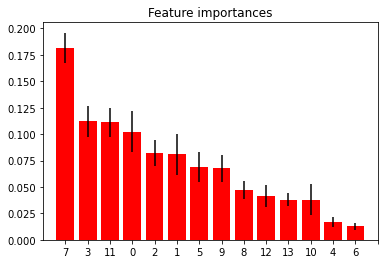

In [47]:
X = X.fillna(0)
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

f_list = []
for f in range(X_train_ros[SELECTED_FEATURE_NAMES].shape[1]):
    f_list.append(indices[f])
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_ros[SELECTED_FEATURE_NAMES].shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X_train_ros[SELECTED_FEATURE_NAMES].shape[1]])
plt.show()

In [48]:
list(X_train_ros[SELECTED_FEATURE_NAMES].columns[f_list])

['Current Loan Amount_',
 'Maximum Open Credit_',
 'Years in current job_',
 'Annual Income_',
 'Years of Credit History_',
 'Number of Open Accounts_',
 'Months since last delinquent_',
 'Monthly Debt_',
 'Current Credit Balance_',
 'Purpose_',
 'Term_',
 'Home Ownership_',
 'Number of Credit Problems_',
 'Bankruptcies_']

#### CatBoostClassifier

In [49]:
feature_importances = pd.DataFrame(zip(X_train_ros[SELECTED_FEATURE_NAMES].columns,
                                       model_cb.feature_importances_ / model_cb.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
7,Current Loan Amount_,0.183774
3,Maximum Open Credit_,0.115567
0,Annual Income_,0.111494
11,Years in current job_,0.085898
1,Number of Open Accounts_,0.078045
10,Home Ownership_,0.066302
2,Years of Credit History_,0.065946
9,Monthly Debt_,0.060449
13,Term_,0.058251
5,Months since last delinquent_,0.054097


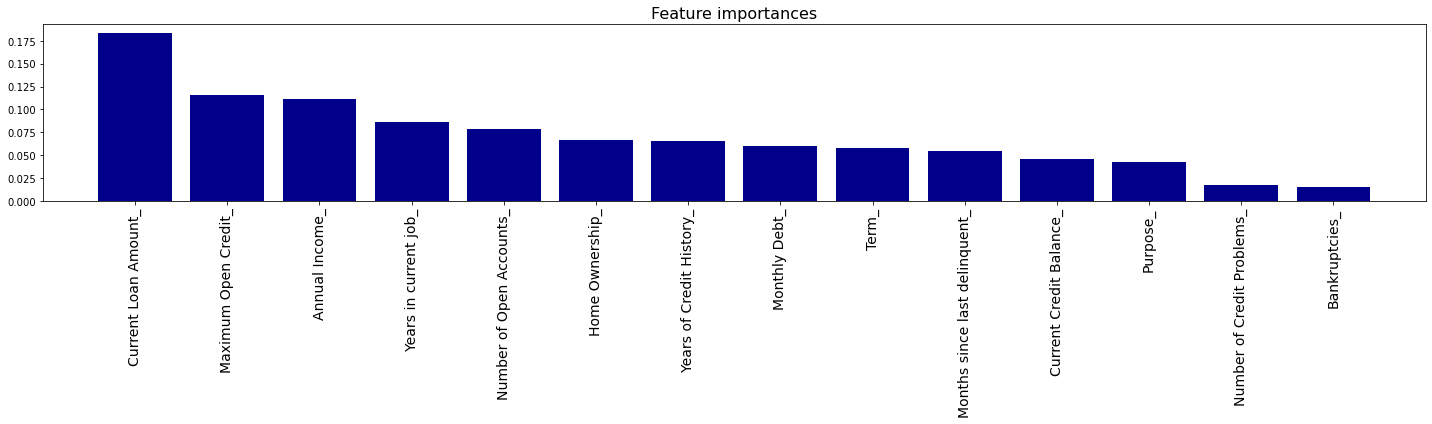

In [50]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model_cb.feature_importances_, X=X_train_ros[SELECTED_FEATURE_NAMES])

## Прогнозирование на тестовом датасете

#### Балансировка классов

In [51]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 5387, 1: 2113})
Resample dataset shape Counter({0: 5387, 1: 5387})


In [52]:
features = FeatureGenerator(bin_split_numeric, bin_split_categorical)
features.fit(X_ros, y_ros)
X_ros = features.transform(X_ros)
X_final = features.transform(X_final)

#### Обучение модели на полном наборе данных

In [53]:
model = model.fit(X_ros[SELECTED_FEATURE_NAMES].fillna(0), y_ros)

#### Прогнозирование целевой переменной

In [54]:
y_pred = model.predict(X_final[SELECTED_FEATURE_NAMES].fillna(0))
y_final=pd.DataFrame(y_pred, columns=[TARGET_NAME])
y_final.to_csv(PATH + 'YKutovaya_predictions.csv')
y_final.head()

,Credit Default
0,1
1,1
2,1
3,0
4,0
